# Finetuning with FasterRCNN

This file perform finetuning based on the pre-trained faster_rcnn model (fasterrcnn_resnet50_fpn).

The purposes of this implementation are understanding;

1. the whole process of finetuning

2. the way to create own Dataset, Dataloader, Transformer and training iterations

2. the structures and the specification of the pre-trained model, namely `fasterrcnn_resnet50_fpn`

3. how to read PyTorch raw codes to know the typical implementation of models

This implementation has been done by customising [TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

Dataset for finetuing is Pascal VOC 2012 images, whereas the model was originally trained by COCO train2017 as [pytorch docs](https://pytorch.org/docs/stable/torchvision/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) says.


## Result of reading PyTorch codes

According to the [implementation of the model](https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py#L24), there are 3 things to know about the specification of fasterrcnn_resnet50_fpn.

1. Normalization

    While running the model, [normalization is performed implicitly](https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py#L227) with the parameter below
    - image_mean = [0.485, 0.456, 0.406]
    - image_std = [0.229, 0.224, 0.225]

    Hence, normalization should not be done in advance such as transform in Dataset if calling faster_rcnn.py.
    
2. Input of the model for training

    During training, the model expects that labels are a list of dictionary. Their keys are:
        - boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with values
          between 0 and H and 0 and W
        - labels (Int64Tensor[N]): the class label for each ground-truth box

3.  Input and Output of the model for validation

    > During inference, the model requires only the input tensors, and returns the post-processed
    predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as
    follows:
        - boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format, with values between
          0 and H and 0 and W
        - labels (Int64Tensor[N]): the predicted labels for each image
        - scores (Tensor[N]): the scores or each prediction

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torchvision

# Utility function

In [ ]:
import os
import glob
def make_datapath_list(path_to_data):
    imgpath_tmpl = os.path.join(path_to_data, "Images", "*.jpg")
    annopath_tmpl = os.path.join(path_to_data, "annotations", "*.xml")
    img_list = [path for path in glob.glob(imgpath_tmpl)]
    annot_list = [path for path in glob.glob(annopath_tmpl)]
    
    return img_list, annot_list

Check the result

In [ ]:
# path_ = "./"
path_ = "/content/drive/My Drive/Colab Notebooks/INM705/week03/"
img_list, annot_list = make_datapath_list(path_)
print(img_list[0])
print(annot_list[0])

/content/drive/My Drive/Colab Notebooks/INM705/week03/Images/2010_000148.jpg
/content/drive/My Drive/Colab Notebooks/INM705/week03/annotations/2010_000160.xml


# Read pre-trained model

- NMS: Non Maximum Suppression
    - If there are multiple bounding boxes for one object, keep the one having the maximum confidence

In [ ]:
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
 

# Modify Model

Modify the number of out_features from 91 to 21 in cls_score.

21 denotes the number of classes in Pascal VOC 2012.

It induces the change of out_features in bbox_pred from 364 (91 * 4) to 84 (21 * 4)

### Replace the last layer

Replacing 2 layers respectively below is the wrong way.

``` python
from torch import nn
frcnn_model.roi_heads.box_predictor.cls_score = nn.Linear(in_features=1024, out_features=21)
frcnn_model.roi_heads.box_predictor.bbox_pred = nn.Linear(in_features=1024, out_features=84)
```

Replacing `FastRCNNPredictor` is the right way.

In [ ]:
from torch import nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 21)
print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=21, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=84, bias=True)
)


# Transformer

DO NOT resize and normalization here as discribed before.

They will be internally and automatically done in the model when training.

Here, only converting into Tensor.

In [ ]:
from torchvision import transforms
class Transofrm:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])
    
    def __call__(self, img):
        return self.transform(img)

# Dataset

To convert class name in XML file into class id, create a mapping dictionary.

In [ ]:
pascal_object_class = ['__bgr__', 'aeroplane', 'bicycle', 'bird', 'boat',
                     'bottle', 'bus', 'car', 'cat', 'chair',
                      'cow', 'diningtable', 'dog', 'horse',
                      'motorbike', 'person', 'pottedplant',
                     'sheep', 'sofa', 'train', 'tvmonitor']
map_name2id = {}
for id, name in enumerate(pascal_object_class):
    map_name2id[name] = id

print(map_name2id)

{'__bgr__': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


According to [the document](https://github.com/pytorch/vision/blob/master/torchvision/models/detection/faster_rcnn.py#L28) or [Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#defining-the-dataset),

1. The dataset __getitem__ should return tensor of `image` and dict of `target`.
    - target consists of `boxes` and `labels`

In [ ]:
from torch.utils import data
import PIL
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt

class Dataset(data.Dataset):
    def __init__(self, img_path_list, anno_path_list, map_name2id, transform=None):
        self.img_path_list = img_path_list
        self.anno_path_list = anno_path_list
        self.map_name2id = map_name2id
        self.transform = transform
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, i):
        img_path = self.img_path_list[i]
        anno_path = self.anno_path_list[i]

        img = PIL.Image.open(img_path).convert("RGB")
        label = self.__get_label(anno_path)
    
        if self.transform:
            img = self.transform(img)
        
        return img, label
        
    def __get_label(self, p):
        root = ET.parse(p).getroot()
        target = {"labels": [], "boxes": []}

        for elm in root.findall('object'):
            for name in elm.findall("name"):
                label_id = self.map_name2id[name.text]
                target["labels"].append(label_id)

            for bndbox in elm.findall("bndbox"):
                xmin = int(bndbox.find("xmin").text)
                ymin = int(bndbox.find("ymin").text)
                xmax = int(bndbox.find("xmax").text)
                ymax = int(bndbox.find("ymax").text)
                target["boxes"].append([xmin, ymin, xmax, ymax])

        target["labels"] = torch.as_tensor(target["labels"], dtype=torch.int64)
        target["boxes"] = torch.as_tensor(target["boxes"], dtype=torch.float)
        
        return target
    
    def show_img(self, i):
        img, label = self.__getitem__(i)
        img = img.numpy().transpose((1,2,0))
        plt.imshow(img)

## Helper modules

To use the warmup_lr_scheduler, import some helper modules.

warmup_lr_scheduler gradually changes the learning rate from 0 to the specified rate in the 1st epoch.

The commands below are runnable on Google Colab (or probably MacOS)

In [ ]:
# Download TorchVision repo to use some files from
# references/detection
# !git clone https://github.com/pytorch/vision.git

# for google colab
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git


Cloning into 'vision'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 6897 (delta 18), reused 35 (delta 12), pack-reused 6850
Receiving objects: 100% (6897/6897), 9.80 MiB | 22.20 MiB/s, done.
Resolving deltas: 100% (4641/4641), done.


In [ ]:
from vision.references.detection import utils

Create instances from data.Dataset.

`for i in data_loader:` usually have to have the same size of Tensor. 

However, we would like to get the different size of tensor because each image has different size.

If specifying `collate_fn=utils.collate_fn`, `utils.collate_fn` is used to provide the return from dataloader.

`utils.collate_fn` does not have the limitation that all of data (images) have the same shape.

In [ ]:
transform = Transofrm()
dataset = Dataset(img_list, annot_list, map_name2id, transform)

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4, 
    collate_fn=utils.collate_fn)

In [ ]:
dataset[0]

(tensor([[[0.2353, 0.2353, 0.2157,  ..., 0.0745, 0.0667, 0.1255],
          [0.2275, 0.2078, 0.1882,  ..., 0.0902, 0.0980, 0.1529],
          [0.2431, 0.2235, 0.2471,  ..., 0.0588, 0.0902, 0.1451],
          ...,
          [0.4196, 0.3725, 0.2980,  ..., 0.6392, 0.6941, 0.6627],
          [0.4157, 0.3765, 0.4157,  ..., 0.7216, 0.7255, 0.6824],
          [0.4078, 0.3569, 0.3725,  ..., 0.6706, 0.6627, 0.6275]],
 
         [[0.2471, 0.2627, 0.2549,  ..., 0.1020, 0.0941, 0.1529],
          [0.2392, 0.2353, 0.2275,  ..., 0.1176, 0.1255, 0.1804],
          [0.2549, 0.2510, 0.2941,  ..., 0.0980, 0.1294, 0.1843],
          ...,
          [0.5255, 0.4784, 0.4118,  ..., 0.6353, 0.6902, 0.6588],
          [0.5137, 0.4745, 0.5137,  ..., 0.7176, 0.7216, 0.6784],
          [0.4941, 0.4431, 0.4667,  ..., 0.6667, 0.6588, 0.6235]],
 
         [[0.2039, 0.2000, 0.1608,  ..., 0.0745, 0.0627, 0.1216],
          [0.1961, 0.1725, 0.1333,  ..., 0.0902, 0.0941, 0.1490],
          [0.2196, 0.1882, 0.2000,  ...,

In [ ]:
print(len(dataset))

2913


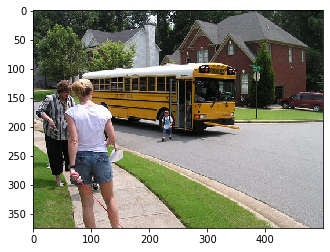

In [ ]:
dataset.show_img(0)

# Optimiser

Since it is fine tuning (or transfer learning), only training weights and bias in the last layer.

In [ ]:
params_to_update = []

update_param_names = ["roi_heads.box_predictor.cls_score.weight",
                      "roi_heads.box_predictor.cls_score.bias"]

for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False

Using learning scheudler: [StepLR](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR)

Every 3 times of calling `scheduler.step()`, Learning rate will be LR = LR * 0.1

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 21

model.to(device)

optimizer = torch.optim.SGD(params_to_update, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Check how many parameters will be trained.

It should be 2, weights and bias in the last layer.

In [ ]:
def cnt_grad_param(optimizer):
    cnt = 0
    for param in optimizer.param_groups[0]["params"]:
        cnt += 1 if param.requires_grad else 0
    print(cnt)
cnt_grad_param(optimizer)

2


# Training

This implementation refers to [train_one_epoch](https://github.com/pytorch/vision/blob/master/references/detection/engine.py#L13) which is using in the tutorial.

In [ ]:
num_epochs = 2
iter_num = len(data_loader)
total_loss = 0

for epoch in range(num_epochs):
    lr_scheduler = None
    
    if epoch == 0: 
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for id, batch in enumerate(data_loader):
        images, targets = batch

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()
            print("[LR]", "{:.10f}".format(optimizer.param_groups[0]["lr"]))
            

        print(f"[{epoch+1}/{num_epochs}][Loss] {id+1}/{iter_num}: {losses}")

[LR] 0.0000099950
[1/2][Loss] 1/1457: 3.4393808841705322
[LR] 0.0000149900
[1/2][Loss] 2/1457: 5.792282581329346
[LR] 0.0000199850
[1/2][Loss] 3/1457: 3.430039167404175
[LR] 0.0000249800
[1/2][Loss] 4/1457: 3.3896090984344482
[LR] 0.0000299750
[1/2][Loss] 5/1457: 3.3530948162078857
[LR] 0.0000349700
[1/2][Loss] 6/1457: 3.4745683670043945
[LR] 0.0000399650
[1/2][Loss] 7/1457: 3.7957940101623535
[LR] 0.0000449600
[1/2][Loss] 8/1457: 3.462636947631836
[LR] 0.0000499550
[1/2][Loss] 9/1457: 3.3462719917297363
[LR] 0.0000549500
[1/2][Loss] 10/1457: 3.554708957672119
[LR] 0.0000599450
[1/2][Loss] 11/1457: 3.1098315715789795
[LR] 0.0000649400
[1/2][Loss] 12/1457: 3.2734670639038086
[LR] 0.0000699350
[1/2][Loss] 13/1457: 3.3103842735290527
[LR] 0.0000749300
[1/2][Loss] 14/1457: 2.908374071121216
[LR] 0.0000799250
[1/2][Loss] 15/1457: 2.9495415687561035
[LR] 0.0000849200
[1/2][Loss] 16/1457: 2.725112199783325
[LR] 0.0000899150
[1/2][Loss] 17/1457: 2.669196605682373
[LR] 0.0000949100
[1/2][Loss] 

In [ ]:
# pick one image from the test set
img, out = dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
    print(prediction[0]["scores"])

tensor([0.6327, 0.5268, 0.5131, 0.3268, 0.3046, 0.2895, 0.2206, 0.1944, 0.1912,
        0.1745, 0.1742, 0.1742, 0.1719, 0.1536, 0.1371, 0.1363, 0.1265, 0.1251,
        0.1209, 0.1143, 0.1124, 0.1082, 0.1055, 0.1007, 0.1005, 0.0990, 0.0944,
        0.0907, 0.0857, 0.0704, 0.0701, 0.0697, 0.0689, 0.0649, 0.0644, 0.0633,
        0.0600, 0.0597, 0.0591, 0.0570, 0.0563, 0.0546, 0.0545, 0.0538, 0.0537,
        0.0531, 0.0524, 0.0523, 0.0508, 0.0503, 0.0501], device='cuda:0')


## Bounding Box

torch.Size([3, 375, 500])
(375, 500, 3)
tensor([0.6327, 0.5268, 0.5131, 0.3268, 0.3046, 0.2895, 0.2206, 0.1944, 0.1912,
        0.1745, 0.1742, 0.1742, 0.1719, 0.1536, 0.1371, 0.1363, 0.1265, 0.1251,
        0.1209, 0.1143, 0.1124, 0.1082, 0.1055, 0.1007, 0.1005, 0.0990, 0.0944,
        0.0907, 0.0857, 0.0704, 0.0701, 0.0697, 0.0689, 0.0649, 0.0644, 0.0633,
        0.0600, 0.0597, 0.0591, 0.0570, 0.0563, 0.0546, 0.0545, 0.0538, 0.0537,
        0.0531, 0.0524, 0.0523, 0.0508, 0.0503, 0.0501])


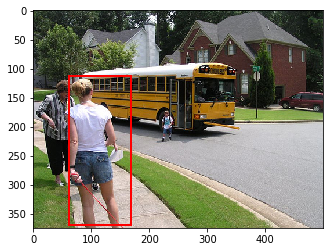

In [ ]:
from matplotlib.patches import Rectangle
import numpy 

model.eval()
with torch.no_grad():
    threshold = 0.6

    scores = prediction[0]['scores'].to("cpu")
    bboxes = prediction[0]['boxes'].to("cpu")
    classes = prediction[0]['labels'].to("cpu")
    best_idx = np.where(scores>threshold)
    best_bboxes = bboxes[best_idx]
    best_classes = bboxes[best_idx]

    if len(best_idx)>0:
        print(img.shape)
        img_tr = img.numpy().transpose((1,2,0))
        print(img_tr.shape)
        plt.imshow(img_tr)
        ax=plt.gca()
        print(scores)
        if best_bboxes.nelement() == 0:
            print("There is no confident bounding boxes.")
        else:
            for b in best_bboxes:
                rect = Rectangle((b[0],b[1]), b[2]-b[0], b[3]-b[1], linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

        plt.show()